In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
import torch.nn as nn
import torch.nn.functional as F

In [2]:
model_path = '../../saved_models/best_model.pth'
half_img = torch.randn(1, 1, 500, 500)  # Example half image (batch_size=1, channels=1, H=500, W=500)
full_img = torch.randn(1, 1, 500, 500)  # Example full image (batch_size=1, channels=1, H=500, W=500)

In [3]:

class Conv2dModel(nn.Module):
    def __init__(self, cnn_out):
        super(Conv2dModel, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x250x250
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x125x125
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x62x62
            nn.Flatten(),
            
            nn.Linear(128 * 62 * 62, cnn_out),
            nn.ReLU()
        )

    

    def forward(self, img):
        x = self.cnn(img)
        return x
        

class Encoder(nn.Module):
    def __init__(self, cnn_out_dim,output_dim):
        super(Encoder, self).__init__()
        
        self.half_cnn = Conv2dModel(cnn_out_dim)
        self.full_cnn = Conv2dModel(cnn_out_dim)
        # Combine half image and full image encodings
        self.fc = nn.Sequential(
            nn.Linear(cnn_out_dim*2, output_dim),  # Combine the two CNN outputs
            nn.ReLU()
        )
        
       
    
    def forward(self, half_img, full_img):
       
        half_img_encoding = self.half_cnn(half_img)
        full_img_encoding = self.full_cnn(full_img)

        
        combined_encoding = torch.cat((half_img_encoding, full_img_encoding), dim=1)
        
        
        latent = self.fc(combined_encoding)
        
        return latent
    
class Decoder(nn.Module):
    def __init__(self, output_dim, input_dim, hidden_dim, n_layers):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hidden, cell):
        # Ensure input shape is (batch_size, seq_length, input_dim)
        input = input.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)
        
        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        prediction = self.fc_out(output)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder,device):
        super(Seq2Seq,self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self,ref_img,half_img,strokes):

        latent = self.encoder(half_img,ref_img)
        

        batch_size = strokes.shape[0]
        trg_length = strokes.shape[1]


        outputs = torch.zeros(trg_length, batch_size, self.decoder.output_dim).to(self.device)

     


        input = strokes[:,0,:]

        outputs[0] = input

        
        

        hidden = latent.unsqueeze(0)  # Shape: (1, batch_size, output_dim)
        cell = latent.unsqueeze(0) 

        

        for i in range(1,trg_length):

            output, hidden, cell = self.decoder(input, hidden, cell)
            output = output.squeeze(1)
            input = output
            
            output[:, 2] = (output[:, 2] > 0.05).float()
            outputs[i] = output

            
            # implemet teacher forcing

        return outputs


In [4]:
# Define the function to load the model and make predictions
def load_model_and_predict_strokes(half_img, full_img, model_path, device='cpu'):
    # Load the saved model
    encoder = Encoder(cnn_out_dim=32, output_dim=64).to(device)
    decoder = Decoder(output_dim=3, input_dim=3, hidden_dim=64, n_layers=1).to(device)
    model = Seq2Seq(encoder, decoder, device).to(device)
    
    # Load the model's weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set the model to evaluation mode

    # Ensure images are on the correct device
    half_img = half_img.to(device)
    full_img = full_img.to(device)

    batch_size = half_img.size(0)
    seq_len = 100  # Example sequence length (adjust as per your dataset)
    fake_strokes = torch.zeros(batch_size, seq_len, 3).to(device)  # Initialize fake strokes
    

    with torch.no_grad():  # No need to calculate gradients during prediction
        predicted_strokes = model(full_img, half_img, fake_strokes)
    

    predicted_strokes = predicted_strokes.permute(1, 0, 2)

    return predicted_strokes  # Return the predicted strokes



predicted_strokes = load_model_and_predict_strokes(half_img, full_img, model_path)


/tmp/ipykernel_66131/94259768.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [5]:
def strokeToImage(strokes):

    
    x, y = strokes[0][0], strokes[0][1]

    # Create a figure and canvas to render the plot
    fig, ax = plt.subplots(figsize=(5, 5))
    canvas = FigureCanvas(fig)
    
    for stroke in strokes:
        dx, dy, pen_up = stroke
        
        
        new_x, new_y = x+dx, y+dy  

        if pen_up == 0:
            ax.plot([x,new_x], [y,new_y], color='black')

        x, y = new_x, new_y

    # Set limits for the plot
    ax.set_xlim(-500, 500)
    ax.set_ylim(-500, 500)
    
    # Remove axis ticks and labels for a clean image
    ax.axis('off')

    # Render the plot to the canvas
    canvas.draw()

    # Convert the canvas to a NumPy array
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    
    # Get the width and height from the figure
    width, height = fig.get_size_inches() * fig.get_dpi()

    # Reshape the buffer to the correct dimensions (height, width, 3) for an RGB image
    image = image.reshape(int(height), int(width), 3)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # bw_img will be of shape (32, 32)

    
    plt.close(fig)
    
    return img

In [9]:
img=strokeToImage(predicted_strokes[0])

/tmp/ipykernel_66131/420411782.py:32: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


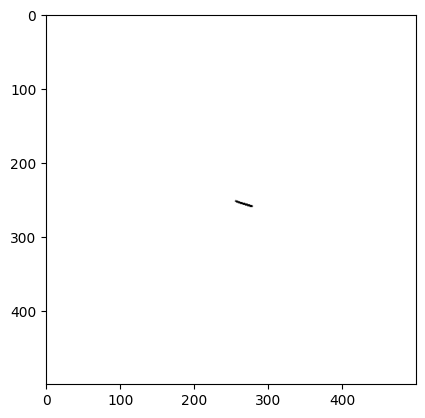

In [10]:
plt.imshow(img,cmap='gray')